In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import os
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import cv2

In [2]:
from google.colab import drive

drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [3]:
import shutil
shutil.copy('/content/gdrive/Shareddrives/CV/cnn/test.zip', 'test.zip')
shutil.copy('/content/gdrive/Shareddrives/CV/cnn/newTrain.zip', 'train.zip')
shutil.copy('/content/gdrive/Shareddrives/CV/cnn/valid.zip', 'valid.zip')
!unzip test.zip
!unzip train.zip
!unzip valid.zip
shutil.copy('/content/gdrive/Shareddrives/CV/cnn/test.csv', 'test.csv')
shutil.copy('/content/gdrive/Shareddrives/CV/cnn/newTrain.csv', 'train.csv')
shutil.copy('/content/gdrive/Shareddrives/CV/cnn/valid.csv', 'valid.csv')

Streaming output truncated to the last 5000 lines.
  inflating: newTrain/cnn7825.data   
  inflating: newTrain/cnn7826.data   
  inflating: newTrain/cnn7827.data   
  inflating: newTrain/cnn7829.data   
  inflating: newTrain/cnn783.data    
  inflating: newTrain/cnn7830.data   
  inflating: newTrain/cnn7831.data   
  inflating: newTrain/cnn7832.data   
  inflating: newTrain/cnn7833.data   
  inflating: newTrain/cnn7835.data   
  inflating: newTrain/cnn7836.data   
  inflating: newTrain/cnn7837.data   
  inflating: newTrain/cnn7838.data   
  inflating: newTrain/cnn784.data    
  inflating: newTrain/cnn7841.data   
  inflating: newTrain/cnn7842.data   
  inflating: newTrain/cnn7843.data   
  inflating: newTrain/cnn7844.data   
  inflating: newTrain/cnn7845.data   
  inflating: newTrain/cnn7846.data   
  inflating: newTrain/cnn7847.data   
  inflating: newTrain/cnn7848.data   
  inflating: newTrain/cnn785.data    
  inflating: newTrain/cnn7850.data   
  inflating: newTrain/cnn7852.data   

'valid.csv'

In [4]:
class XRayCNNDataset(Dataset):
    # root_dir example: r'D:xray/cnn/train'
    # annotation_file example: r'train.csv'
    def __init__(self, root_dir, annotation_file):
        self.root_dir = root_dir
        self.annotations = pd.read_csv(annotation_file)
    
    def __len__(self):
        return len(self.annotations)
    
    def __getitem__(self, index):
        file_name = self.annotations._get_value(index, 'image_id')
        label = self.annotations._get_value(index, 'class_id')
        file = open(os.path.join(self.root_dir, file_name), 'rb')
#         img = pickle.load(file)
#         img = cv2.resize(img, dsize=(32, 32), interpolation=cv2.INTER_CUBIC)
#         img = np.array([img.copy(), img.copy(), img.copy()])
        img = np.array([pickle.load(file)])
        file.close()
        img = img.astype('float32')
        return (img, label)

In [5]:
class ConvBNNet(nn.Module):
    def __init__(self):
        super(ConvBNNet, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        # Input 64x64x1 image
        # 16 filters
        # 3x3 filter size (they also have 3 channels)
        # stride 2 (downsampling by factor of 2)
        # Output image: 32x32x16
        self.conv1 = nn.Conv2d(1, 16, 5, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        # Input 32x32x16 image
        # 32 filters
        # 3x3x16 filter size (they also have 16 channels)
        # stride 2 (downsampling by factor of 2)
        # Output image: 16x16x32
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Exercise left to the reader
        # Output image: 4x4x64 -> 1024 neurons
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        self.fc1 = nn.Linear(4096, 14)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [11]:
class CustomNet4(nn.Module):
    def __init__(self):
        super(CustomNet4, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        # Input 64x64x1 image
        # 16 filters
        # 3x3 filter size (they also have 3 channels)
        # stride 2 (downsampling by factor of 2)
        # Output image: 32x32x16
        self.conv1 = nn.Conv2d(1, 16, 5, stride=2, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        # Input 32x32x16 image
        # 32 filters
        # 3x3x16 filter size (they also have 16 channels)
        # stride 2 (downsampling by factor of 2)
        # Output image: 16x16x32
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        # Exercise left to the reader
        # Output image: 8x8x64 -> 1024 neurons
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        
        # Exercise left to the reader
        # Output image: 8x8x128 -> 2048 neurons
        self.conv4 = nn.Conv2d(64, 128, 3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(128)
        
        self.fc1 = nn.Linear(8192, 14)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

In [6]:
def get_data(batch_size=128):
    trainset = XRayCNNDataset(r'train', 'train.csv')
    trainloader  = DataLoader(trainset, batch_size=batch_size, shuffle=True)

    validset = XRayCNNDataset(r'valid', 'valid.csv')
    validloader  = DataLoader(validset, batch_size=batch_size, shuffle=False)
    
    testset = XRayCNNDataset(r'test', 'test.csv')
    testloader  = DataLoader(testset, batch_size=batch_size, shuffle=False)
    
    classes = ['Aortic enlargement', 'Atelectasis', 'Calcification', 'Cardiomegaly',
               'Consolidation', 'ILD', 'Inflitration', 'Lung Opacity', 'Nodule/Mass', 'Other lesion',
               'Pleural effusion', 'Pleural thickening', 'Pneumothorax', 'Pulmonary fibrosis']
    return {'train': trainloader, 'test': testloader, 'valid':validloader, 'classes': classes}

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [7]:
def train(net, dataloader, epochs=1, lr=0.01, momentum=0.9, decay=0.0, verbose=0):
    net.to(device)
    losses = []
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.SGD(net.parameters(), lr=lr, momentum=momentum, weight_decay=decay)
    for epoch in range(epochs):
        sum_loss = 0.0
        for i, batch in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = batch[0].to(device), batch[1].to(device)
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize 
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # autograd magic, computes all the partial derivatives
            optimizer.step() # takes a step in gradient direction

            # print statistics
            losses.append(loss.item())
            sum_loss += loss.item()
            if i % 100 == 99:    # print every 100 mini-batches
                if verbose:
                    print('[%d, %5d] loss: %.3f' %
                        (epoch + 1, i + 1, sum_loss / 100))
                sum_loss = 0.0
    return losses

def accuracy(net, dataloader):
    correct = 0
    total = 0
    with torch.no_grad():
        for batch in dataloader:
            images, labels = batch[0].to(device), batch[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct/total

def smooth(x, size):
    return np.convolve(x, np.ones(size)/size, mode='valid')

In [8]:
def anneal(net, data, startingLR=0.001, epochsPerLR=10, momentum=0.9, decay=0.0, numAnnealing=3, verbose=0):
    losses = []
    lr = startingLR
    for i in range(numAnnealing):
        losses += train(net, data, epochsPerLR, lr=lr, momentum=momentum, decay=decay, verbose=verbose)
        lr /= 10
    return losses

In [13]:
def hyperparams():
    learning_rate = np.random.uniform(1e-4, 1e-1)
    momentum = np.random.uniform(0.7, 1)
    decay = np.random.uniform(0.00045, 0.05) # 0.025
    # batch_size = np.random.choice([32, 64, 128, 256])
    batch_size = 256
    return learning_rate, momentum, decay, batch_size

In [ ]:
best_train = 0
best_train_params = []
best_test = 0
best_test_params = []
best_valid = 0
best_valid_params = []
iteration = 0
while 1:
    learning_rate, momentum, decay, batch_size = hyperparams()
    data = get_data((int)(batch_size))
    convb_anneal_net = CustomNet4()
    convb_anneal_loss = anneal(convb_anneal_net, data['train'], startingLR=learning_rate, epochsPerLR=12, momentum=momentum, decay=decay, numAnnealing=4)
    # tr_a = accuracy(convb_anneal_net, data['train'])
    tv_a = accuracy(convb_anneal_net, data['valid'])
    # te_a = accuracy(convb_anneal_net, data['test'])
    # if tr_a > best_train:
    #     best_train = tr_a
    #     best_train_params = [learning_rate, momentum, decay, batch_size]
    #     print(f'{iteration}: Best Train Params: {best_train_params}')
    # if te_a > best_test:
    #     best_test = te_a
    #     best_test_params = [learning_rate, momentum, decay, batch_size]
    #     print(f'{iteration}: Best Test Params: {best_test_params}')
    print(f"{iteration}: Validation accuracy: %f" % tv_a)
    if tv_a > best_valid:
      best_valid = tv_a
      best_valid_params = [learning_rate, momentum, decay, batch_size]
      print(f'{iteration}: Best Valid Params: {best_valid_params}')
      tr_a = accuracy(convb_anneal_net, data['train'])
      te_a = accuracy(convb_anneal_net, data['test'])
      print(f"{iteration}: Training accuracy: %f" % tr_a)
      print(f"{iteration}: Testing  accuracy: %f" % te_a)
    iteration += 1
plt.plot(smooth(convb_anneal_loss, 50))

0: Validation accuracy: 0.694094
0: Best Valid Params: [0.08909059241406314, 0.7292846242711548, 0.038026162663466756, 256]
0: Training accuracy: 0.703505
0: Testing  accuracy: 0.690043
1: Validation accuracy: 0.664897
2: Validation accuracy: 0.663238
3: Validation accuracy: 0.706702
3: Best Valid Params: [0.09279277510105735, 0.7971549669081547, 0.01198030725468292, 256]
3: Training accuracy: 0.760944
3: Testing  accuracy: 0.704007
4: Validation accuracy: 0.698407
5: Validation accuracy: 0.714665
5: Best Valid Params: [0.06623874377072568, 0.7170432686027145, 0.022775735976649985, 256]
5: Training accuracy: 0.758829
5: Testing  accuracy: 0.712508
6: Validation accuracy: 0.707697
7: Validation accuracy: 0.699071
8: Validation accuracy: 0.716324
8: Best Valid Params: [0.018701115412714076, 0.9427748506406288, 0.019763707261864653, 256]
8: Training accuracy: 0.765107
8: Testing  accuracy: 0.709472
9: Validation accuracy: 0.694426
10: Validation accuracy: 0.657930
11: Validation accuracy:

In [ ]:
convb_net = ConvBNNet()

convb_losses = train(convb_net, data['train'], epochs=15, lr=.001, decay=0.025)

plt.plot(smooth(convb_losses, 50))

print("Training accuracy: %f" % accuracy(convb_net, data['train']))
print("Testing  accuracy: %f" % accuracy(convb_net, data['test']))

In [ ]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__() # https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html
        # Input 64x64x1 image
        # 16 filters
        # 3x3 filter size (they also have 3 channels)
        # stride 2 (downsampling by factor of 2)
        # Output image: 32x32x16
        self.conv1 = nn.Conv2d(1, 16, 5, stride=2, padding=1)

        # Input 32x32x16 image
        # 32 filters
        # 3x3x16 filter size (they also have 16 channels)
        # stride 2 (downsampling by factor of 2)
        # Output image: 16x16x32
        self.conv2 = nn.Conv2d(16, 32, 3, stride=2, padding=1)


        # Exercise left to the reader
        # Output image: 4x4x64 -> 1024 neurons
        self.conv3 = nn.Conv2d(32, 64, 3, stride=2, padding=1)

        self.fc1 = nn.Linear(4096, 14)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        return x

100%|██████████████████████████████████████████████████████████████████████████████████| 15/15 [04:34<00:00, 18.33s/it]


Training accuracy: 0.637217
Testing  accuracy: 0.617790


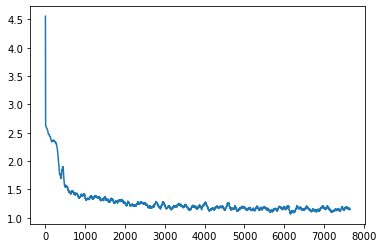

In [ ]:
conv_net = ConvNet()

conv_losses = train(conv_net, data['train'], epochs=15, lr=.001, decay=0.1, verbose=0)

print("Training accuracy: %f" % accuracy(conv_net, data['train']))
print("Testing  accuracy: %f" % accuracy(conv_net, data['test']))
plt.plot(smooth(conv_losses,50))

In [ ]:
simple_anneal_net = SimpleNet()
simple_anneal_losses = anneal(simple_anneal_net, data['train'], startingLR=0.001, epochsPerLR=5, decay=0.1, numAnnealing=3, verbose=0)

print("Training accuracy: %f" % accuracy(simple_anneal_net, data['train']))
print("Testing  accuracy: %f" % accuracy(simple_anneal_net, data['test']))
plt.plot(smooth(simple_anneal_losses,50))


  0%|                                                                                            | 0/5 [00:00<?, ?it/s]


FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\jefff\\Documents\\21Wi\\CSE455\\FinalProject\\cnn\\train\\cnn11457.data'

100%|██████████| 5/5 [00:17<00:00,  3.53s/it]


Training accuracy: 0.666667
Testing  accuracy: 0.643898


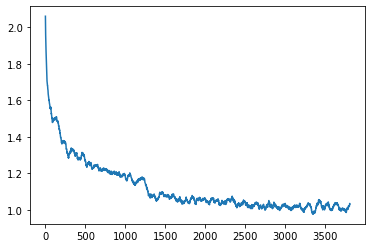

In [ ]:
conv_anneal_net = ConvNet()
conv_anneal_losses = anneal(conv_anneal_net, data['train'], startingLR=0.001, epochsPerLR=5, decay=0.1, numAnnealing=3, verbose=0)

print("Training accuracy: %f" % accuracy(conv_anneal_net, data['train']))
print("Testing  accuracy: %f" % accuracy(conv_anneal_net, data['test']))
plt.plot(smooth(conv_anneal_losses,50))


In [ ]:
class SimpleNet(nn.Module):
    def __init__(self, inputs=4096, hidden=512, outputs=14):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(inputs, hidden)
        self.fc2 = nn.Linear(hidden, outputs)

    def forward(self, x):
        x = torch.flatten(x, 1) # Takes image-like to vector-like
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

In [ ]:
simple_net = SimpleNet(inputs=4096)

losses = train(simple_net, data['train'], epochs=15, lr=.001, decay=0.1, verbose=0)

print("Training accuracy: %f" % accuracy(simple_net, data['train']))
print("Testing  accuracy: %f" % accuracy(simple_net, data['test']))
plt.plot(smooth(losses,50))